In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
from nltk.corpus import stopwords
from textblob import TextBlob 
from textblob import Word
import string
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

In [16]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 1.2 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051302 sha256=18677a4dac1847d82c6c9a610e7e9e37c2e976323153e77136f8bc1f948e499d
  Stored in directory: /tmp/pip-ephem-wheel-cache-6bpgitgj/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [17]:
import string
import en_core_web_md
nlp = en_core_web_md.load()
from spacy.lang.en.stop_words import STOP_WORDS
import re

In [18]:
# Importing the train and test datasets
train = pd.read_csv('/content/drive/MyDrive/JEDHA-FullStack/train.csv')
train.describe(include='all')


In [150]:
test = pd.read_csv('/content/drive/MyDrive/JEDHA-FullStack/test.csv')

In [19]:
# Do we have missing values ?
display(train.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [20]:
# Basic description of the train dataset
train.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [21]:
# There is too many missing values in the Location column, it won't be useful.
train = train.drop(columns=['location'], axis=1)

In [22]:
# The distribution between the Disaster and Non Disaster tweets is a bit unbalanced, our model might be influenced and predict more 0 than 1.
train["target"].value_counts()/len(train)*100

0    57.034021
1    42.965979
Name: target, dtype: float64

In [23]:
# We still have some missing values in the Keyword column. One thing we can do with Keywords is add them at the end of the Text column.
display(train.isnull().sum())

id          0
keyword    61
text        0
target      0
dtype: int64

In [25]:
# Concatenante Keyword and Text in the Text column
for i in range(len(train)):
  train['text'][i] = train['text'][i] + ' ' + train['keyword'][i]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
# We can now drop the uselss columns
train = train.drop(['keyword', 'index'], axis=1)

In [27]:
# We isolate our text column in a separate object 'text'
text = train['text']
text

0       @bbcmtd Wholesale Markets ablaze http://t.co/l...
1       We always try to bring the heavy. #metal #RT h...
2       #AFRICANBAZE: Breaking news:Nigeria flag set a...
3               Crying out for more! Set me ablaze ablaze
4       On plus side LOOK AT THE SKY LAST NIGHT IT WAS...
                              ...                        
7547    @jt_ruff23 @cameronhacker and I wrecked you bo...
7548    Three days off from work and they've pretty mu...
7549    #FX #forex #trading Cramer: Iger's 3 words tha...
7550    @engineshed Great atmosphere at the British Li...
7551    Cramer: Iger's 3 words that wrecked Disney's s...
Name: text, Length: 7552, dtype: object

In [32]:
# We define a function that will clean the text of its 'impurities' (urls, special characters...)
def clean_text(sentence):
  for i in range(len(text)):
    text[i] = ''.join(text[i])
    text[i] = text[i].replace("#","").replace("@","").replace("-"," ").lower().strip()
    text[i] = text[i].replace("  "," ")
    text[i] = re.sub('https?://\S+|www\.\S+', '', text[i])
    text[i] = re.sub('\d+', '', text[i])
    text[i] = re.sub(r"[^a-zA-Z0-9 -]","", text[i])
  return text[i]

In [33]:
# Total words?
train['total_words'] = train['text'].str.split().str.len()
train['total_words'].sum()

120317

In [34]:
# How many unique words?
uniqueWords = list(set(' '.join(train['text']).lower().split(' ')))
count = len(uniqueWords)
count

28080

In [35]:
# We apply the function to our object 'text'
clean_text(text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: Se

'cramer igers  words that wrecked disneys stock  cnbc  wrecked'

In [36]:
# As with anything written by people, there might be some mispelling or abreviations of words. We will try to use TextBlob to replace the mispelled words by the correct word.
# Checking if function works
train['spell_checked'] = text.apply(lambda x: ''.join(TextBlob(x).correct()))

In [39]:
# How many words did we drop?
uniqueWords2 = list(set(' '.join(train['spell_checked']).lower().split(' ')))
count2 = len(uniqueWords2)
count - count2

14834

In [40]:
# This is what it looks like now!
text

0                 bbcmtd wholesale markets ablaze  ablaze
1       we always try to bring the heavy metal rt  ablaze
2       africanbaze breaking newsnigeria flag set abla...
3                crying out for more set me ablaze ablaze
4       on plus side look at the sky last night it was...
                              ...                        
7547    jtruff cameronhacker and i wrecked you both wr...
7548    three days off from work and theyve pretty muc...
7549    fx forex trading cramer igers  words that wrec...
7550    engineshed great atmosphere at the british lio...
7551    cramer igers  words that wrecked disneys stock...
Name: text, Length: 7552, dtype: object

In [41]:
# Time to lemmatize and remove stopwords from the text
train['token_lemma'] = text.apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [ ]:
train

In [42]:
# We now need to tokenize every word of the text column, in a separate column
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train.token_lemma)
train["tweets_encoded"] = tokenizer.texts_to_sequences(train.token_lemma)

In [43]:
# Saving the results in a csv because it took over an hour to compute!
train.to_csv('train_text_checked.csv')

In [ ]:
tokenizer.word_index

In [83]:
# Again in a separate object, we 'pad' the text : we add tokens at the end of every observation so that they're all the same length
tweets_pad = tf.keras.preprocessing.sequence.pad_sequences(train.tweets_encoded, padding="post", truncating='post', maxlen=20)

In [84]:
# To fit our model, we create a new dataset that only uses our padded text and target 
full_ds = tf.data.Dataset.from_tensor_slices((tweets_pad, train.target))

In [85]:
# We use 80% of the dataset to train on
TAKE_SIZE = int(0.8*train.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(128)

test_data = full_ds.skip(TAKE_SIZE)
test_data = test_data.batch(128)

In [86]:
# Look at a batch of data
for tweet, target in train_data.take(1):
  print(tweet, target)

tf.Tensor(
[[12418  5072   188 ...     0     0     0]
 [  510   149  2364 ...     0     0     0]
 [ 5734   415  2355 ...     0     0     0]
 ...
 [   14    43  3443 ...     0     0     0]
 [ 5433  5434  5435 ...     0     0     0]
 [ 4970   902   148 ...     0     0     0]], shape=(128, 20), dtype=int32) tf.Tensor(
[0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0
 1 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 1 0
 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 1
 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1], shape=(128,), dtype=int64)


In [87]:
# How many words do we have in our vocabulary?
vocab_size = len(tokenizer.word_index)
vocab_size

14554

In [182]:
# Now we can create our Sequential model! Since it is a binary classification, we only have 1 neuron on output.
embedding_dim = 32
model = tf.keras.Sequential([
              tf.keras.layers.Embedding(input_dim = vocab_size, output_dim = 256, input_shape=[tweet.shape[1],],name="embedding"),
              tf.keras.layers.GlobalAveragePooling1D(),
              tf.keras.layers.Dense(32,activation='relu'),
              tf.keras.layers.Dropout(0.1),
              tf.keras.layers.Dense(16, activation='relu'),
              tf.keras.layers.Dense(1,activation='sigmoid')
])

In [183]:
# We choose our optimizer, loss function and evaluation metric
opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.keras.metrics.BinaryAccuracy()

In [184]:
# Combine everything!
model.compile(
               optimizer = opt,
               loss=loss,
               metrics=metrics
)

In [185]:
# Let's save our parameters for later use on our test set!
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs2")

In [186]:
# The training starts here, we decide to run the model on 10 epochs :
history = model.fit(train_data, epochs = 3, validation_data=test_data, callbacks=[tensorboard_callback], batch_size=128)

Epoch 1/3
48/48 [==============================] - 1s 8ms/step - loss: 0.6583 - binary_accuracy: 0.5835 - val_loss: 0.6375 - val_binary_accuracy: 0.5970
Epoch 2/3
48/48 [==============================] - 0s 5ms/step - loss: 0.5115 - binary_accuracy: 0.7901 - val_loss: 0.5321 - val_binary_accuracy: 0.7935
Epoch 3/3
48/48 [==============================] - 0s 5ms/step - loss: 0.3304 - binary_accuracy: 0.8805 - val_loss: 0.4905 - val_binary_accuracy: 0.7776


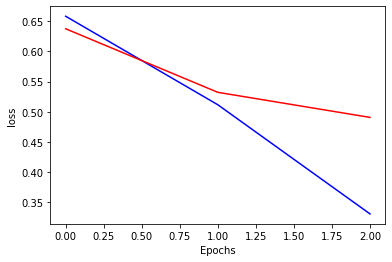

In [187]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

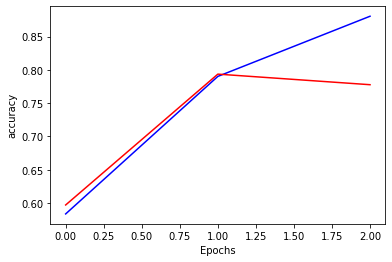

In [188]:
# Visualization of accuracy training 
plt.plot(history.history["binary_accuracy"], color="b")
plt.plot(history.history["val_binary_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [189]:
# The optimal scores for loss and accuracy seem to be around 3 epochs.

In [190]:
# We do the same preprocess on test set as we did on train set

In [154]:
test.fillna('', inplace=True)

In [155]:
test = test.drop(columns=['location'], axis=1)

In [156]:
Counter(test['keyword'].isna() == True)

Counter({False: 3263})

In [157]:
for i in range(len(test)):
  test['text'][i] = test['text'][i] + ' ' + test['keyword'][i]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [158]:
test

,id,keyword,text
0,0,,Just happened a terrible car crash
1,2,,"Heard about #earthquake is different cities, s..."
2,3,,"there is a forest fire at spot pond, geese are..."
3,9,,Apocalypse lighting. #Spokane #wildfires
4,11,,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...
3258,10861,,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,,Storm in RI worse than last hurricane. My city...
3260,10868,,Green Line derailment in Chicago http://t.co/U...
3261,10874,,MEG issues Hazardous Weather Outlook (HWO) htt...


In [159]:
test = test.drop(['keyword'], axis=1)

In [160]:
text = test['text']

In [161]:
clean_text(text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: Se

'cityofcalgary has activated its municipal emergency plan yycstorm'

In [162]:
test['spell_checked'] = text.apply(lambda x: ''.join(TextBlob(x).correct()))

In [163]:
test['token_lemma'] = text.apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [164]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(test.token_lemma)
test["tweets_encoded"] = tokenizer.texts_to_sequences(test.token_lemma)

In [165]:
# Saving the results in a CSV because it took over an hour to compute!
test.to_csv('test_text_checked.csv')

In [166]:
test2 = pd.read_csv('test_text_checked.csv')
test2.describe()

,Unnamed: 0,id
count,3263.000000,3263.000000
mean,1631.000000,5427.152927
std,942.091291,3146.427221
min,0.000000,0.000000
25%,815.500000,2683.000000
50%,1631.000000,5500.000000
75%,2446.500000,8176.000000
max,3262.000000,10875.000000


In [167]:
tweets_pad_test = tf.keras.preprocessing.sequence.pad_sequences(test.tweets_encoded, padding="post", truncating="post", maxlen=20)

In [168]:
tweets_pad_test.shape

(3263, 20)

In [191]:
# We make our predictions
pred = model.predict(tweets_pad_test, batch_size=128)
pred_int = pred.round().astype("int")

In [192]:
# We create a target column to put our predictions in
test["target"] = pred_int

In [193]:
submission = test[['id','target']]

In [172]:
submission.to_csv("submission.csv")

In [175]:
submission_csv = pd.read_csv('submission.csv')

In [177]:
submission_csv = submission_csv.drop(columns='Unnamed: 0')

In [194]:
submission_csv.to_csv("submission_try.csv", index=False)